# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# Evaluate logits and metrics

In [5]:
MODELS = ['efficientnetv2_xl', 'vit_l_16_384','vit_b_32_sam']
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000
METRIC_opt = metrics.AURC
METRIC_plt = metrics.AUROC

In [6]:
RCs = {}
auroc = {}
RCs_baseline = {}
auroc_baseline = {}

for model in MODELS:
    logits_val,labels_val,logits_test,labels_test = split_data.split_logits(*upload_logits(model,DATASET,PATH_MODELS, 
                                split = 'test', device = dev),VAL_SIZE,SEED)
    risk_val = measures.wrong_class(logits_val,labels_val).float()
    risk_test = measures.wrong_class(logits_test,labels_test).float()
    ml_p = post_hoc.MaxLogit_pNorm(logits_test,p='optimal',metric = METRIC_opt,MSP_fallback = True,risk = risk_val, logits_opt = logits_val)
    baseline = measures.MSP(logits_test)
    RCs[model] = metrics.RC_curve(ml_p,risk_test)
    auroc[model] = METRIC_plt(ml_p,risk_test)
    RCs_baseline[model] = metrics.RC_curve(baseline,risk_test)
    auroc_baseline[model] = METRIC_plt(baseline,risk_test)


# Plot

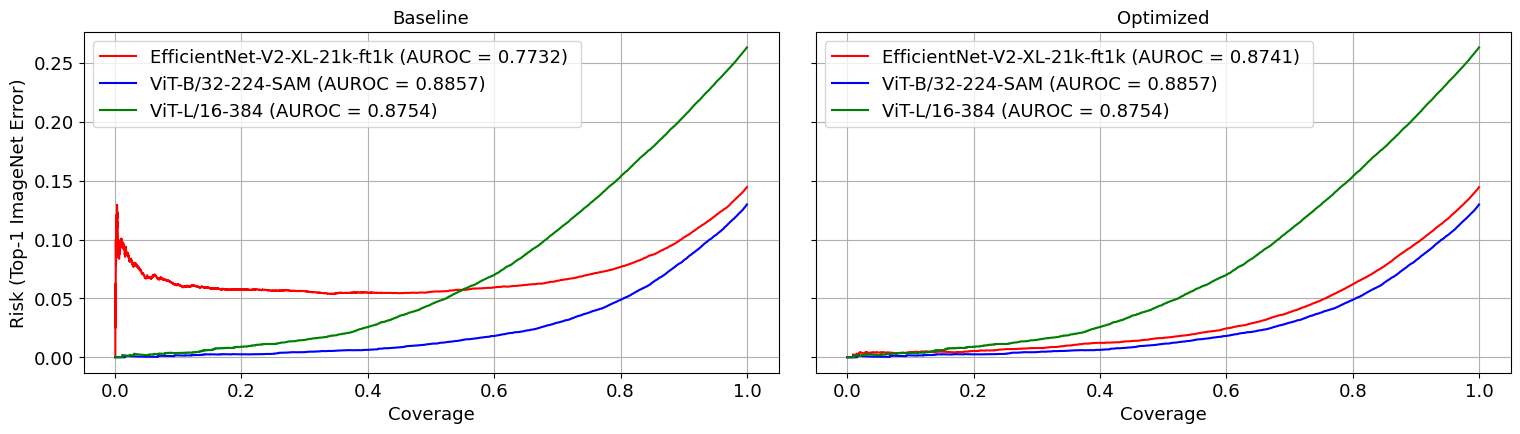

In [7]:
fig,axes = plt.subplots(1,2,sharey = True,figsize = (15,4))
fig.tight_layout()

colors = {'efficientnetv2_xl':'red', 'vit_l_16_384':'blue','vit_b_32_sam':'green'}
names = {'efficientnetv2_xl':'EfficientNet-V2-XL-21k-ft1k', 'vit_l_16_384':'ViT-B/32-224-SAM','vit_b_32_sam':'ViT-L/16-384'}

for n in MODELS:
    axes[0].plot(*RCs_baseline[n],color = colors[n],
              label  = names[n]+ f' (AUROC = {auroc_baseline[n]:.4f}) ')
    axes[1].plot(*RCs[n],color = colors[n],
              label  = names[n]+ f' (AUROC = {auroc[n]:.4f}) ')
axes[0].set_title('Baseline')
axes[1].set_title('Optimized')
axes[0].set_ylabel('Risk (Top-1 ImageNet Error)')
for ax in axes:
    ax.grid()
    ax.legend(prop={'size': 13})
    ax.set_xlabel('Coverage')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
plt.savefig(os.path.join(FIGS_PATH, f'RCs-models.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()